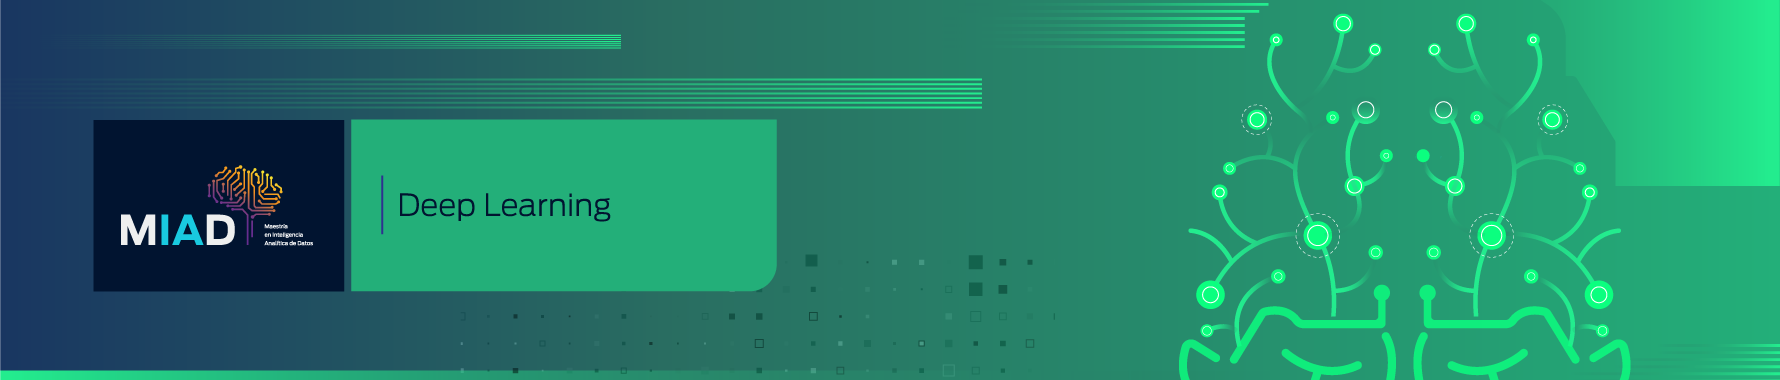

# Redes neuronales usando keras: Comparación de estrategias de regularización


## Actividad calificada por el personal


### Propósito 
En este notebook se pretende evaluar el uso de keras al aplicar una red neuronal en un contexto real haciendo uso de mecanismos de regularización tales como *drop out*, *early stopping*, norma 1 y norma 2 haciendo uso del paquete Keras.

### Instrucciones generales
1. Para desarrollar el notebook, lo deberán descargar a un repositorio (pueden escoger el repositorio de su preferencia) para que lo puedan trabajar grupalmente.

2. Los procedimientos en el notebook deberán responderse en los espacios especificados para tal fin, debajo de cada uno de los puntos.

3. Para que la actividad sea calificada, deberán subir únicamente este mismo archivo con la extensión ".ipynb" a la actividad de "entrega calificada por el personal" correspondiente a este caso.

4. El archivo que suban debe poder ejecutarse localmente cuando sea descargado por el tutor, asumiendo que la base de datos de la actividad ya ha sido importada en el correspondiente archivo separado por comas (.csv).


### Criterios a evaluar
Los criterios que se evaluarán son:   

Análisis preliminar de variables: Se presentan correlogramas, histogramas y estadísticas descriptivas de las variables de la base de datos y se hace un análisis coherente de cada uno de ellos. Realice la partición de la muestra en _train_ y _test_. [5 puntos]

Estimación de un modelo utilizando redes neuronales con *dropout*: Se estima el modelo usando una red neuronal con *dropout* , se evalúa en la muestra de test. [20 puntos]

Estimación de un modelo utilizando redes neuronales con *early stopping*: Se estima el modelo usando una red neuronal con *early stopping*, se evalúa en la muestra de test. [20 puntos]

Estimación de un modelo utilizando redes neuronales con norma 1: Se estima el modelo usando una red neuronal con norma 1, se evalúa en la muestra de test. [20 puntos]

Estimación de un modelo utilizando redes neuronales con norma 2: Se estima el modelo usando una red neuronal con norma 2, se evalúa en la muestra de test. [20 puntos]

Comparación de modelos: Se elige la mejor regularización a partir de una comparación. [15 puntos]

#### Problema
Un manager de un banco manifiesta preocupación porque los clientes están renunciando a las tarjetas de crédito. Este cuenta con los datos disponibles en https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers a cerca de 10000 clientes, si tiene productos activos o no (*"Attrition flag"*), en función de variables tales como edad, salario, estado civil, límite de tarjeta de crédito, categoría de tarjeta de crédito, etc.

Ustedes deben proponer el algoritmo para hacer la clasificación de los clientes con una red neuronal.

Finalmente, para resolver los puntos de esta actividad deberán tener en cuenta únicamente las variables continuas (se deben eliminar las variables categóricas) y deberán eliminar las observaciones con datos faltantes.

### Librerías a importar

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os, random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score,
                             recall_score, f1_score, confusion_matrix, classification_report)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping


SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


### 1. Análisis preliminar de variables [5 puntos]
Realicen un análisis preliminar de los predictores y de la variable de respuesta (correlogramas, histogramas y estadísticas descriptivas).

=== Estadísticos descriptivos (numéricos) ===
                            count          mean           std          min  \
CLIENTNUM                 10127.0  7.391776e+08  3.690378e+07  708082083.0   
Customer_Age              10127.0  4.632596e+01  8.016814e+00         26.0   
Dependent_count           10127.0  2.346203e+00  1.298908e+00          0.0   
Months_on_book            10127.0  3.592841e+01  7.986416e+00         13.0   
Total_Relationship_Count  10127.0  3.812580e+00  1.554408e+00          1.0   
Months_Inactive_12_mon    10127.0  2.341167e+00  1.010622e+00          0.0   
Contacts_Count_12_mon     10127.0  2.455317e+00  1.106225e+00          0.0   
Credit_Limit              10127.0  8.631954e+03  9.088777e+03       1438.3   
Total_Revolving_Bal       10127.0  1.162814e+03  8.149873e+02          0.0   
Avg_Open_To_Buy           10127.0  7.469140e+03  9.090685e+03          3.0   
Total_Amt_Chng_Q4_Q1      10127.0  7.599407e-01  2.192068e-01          0.0   
Total_Trans_Amt   

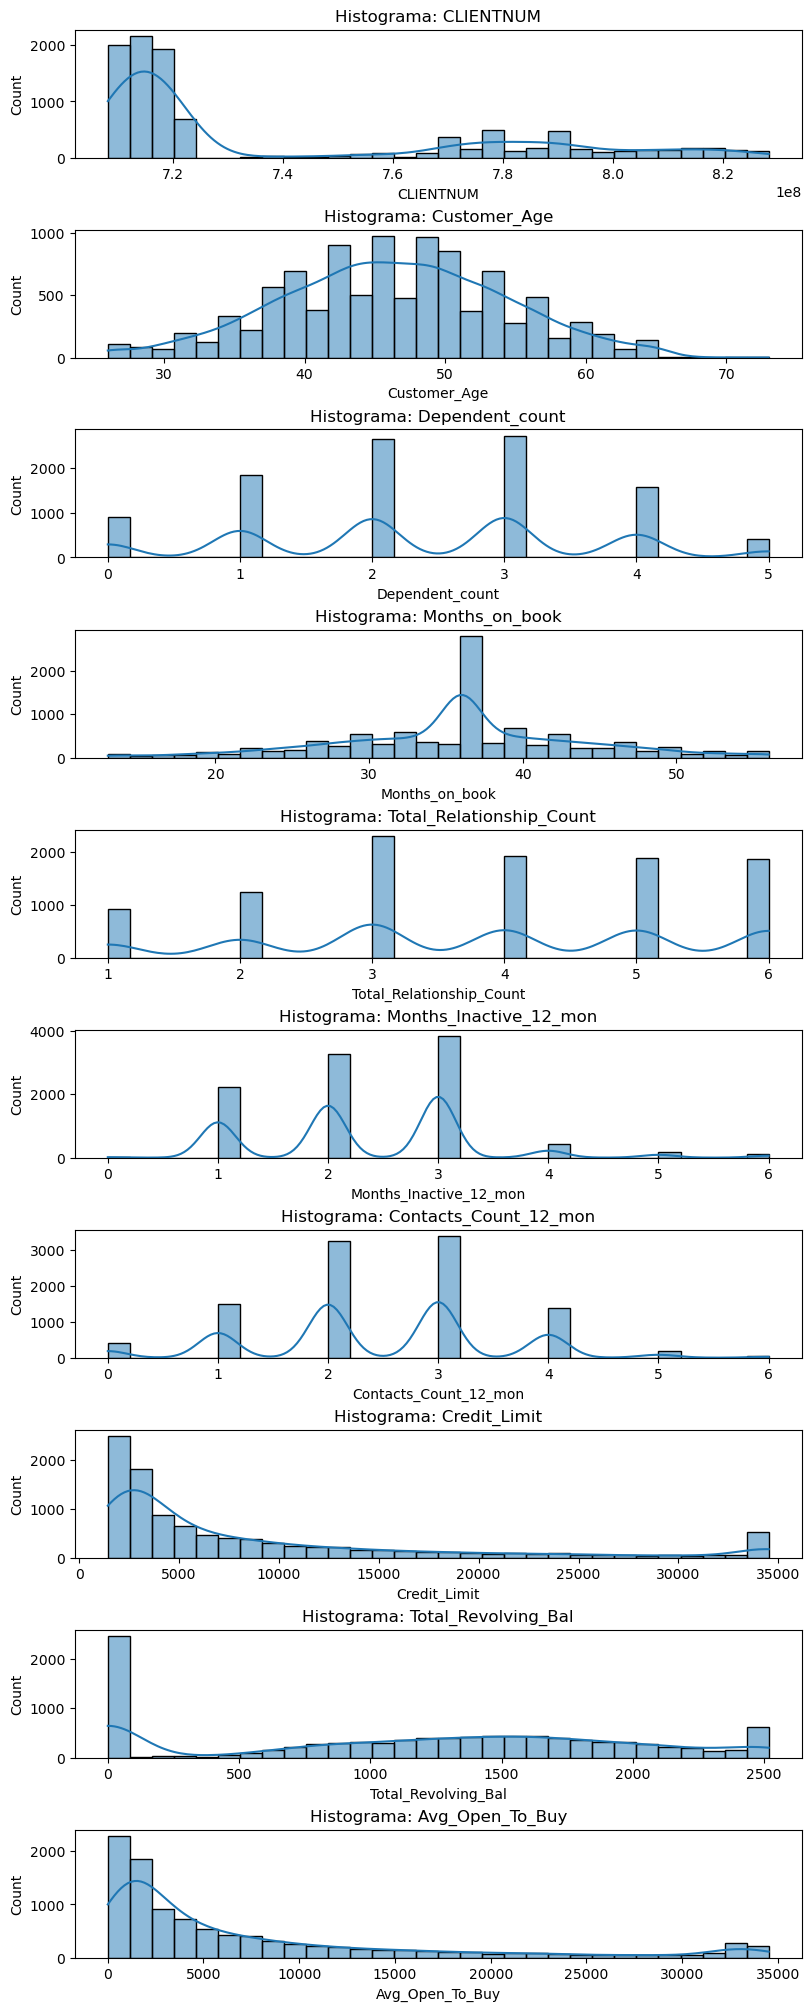

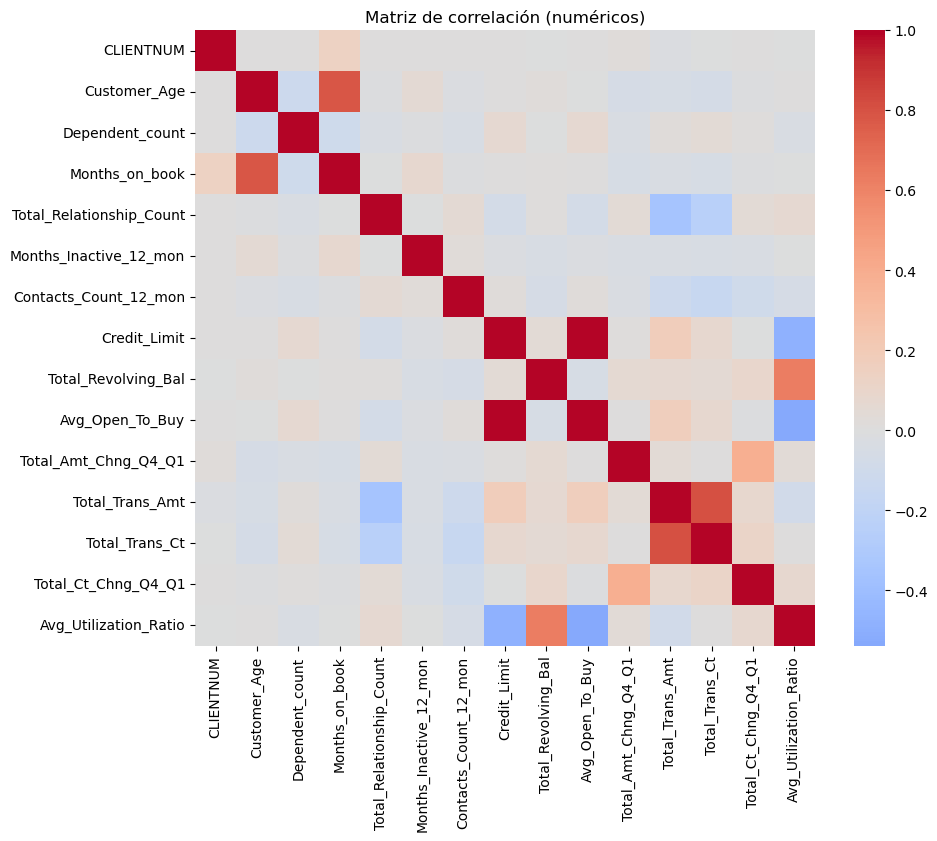

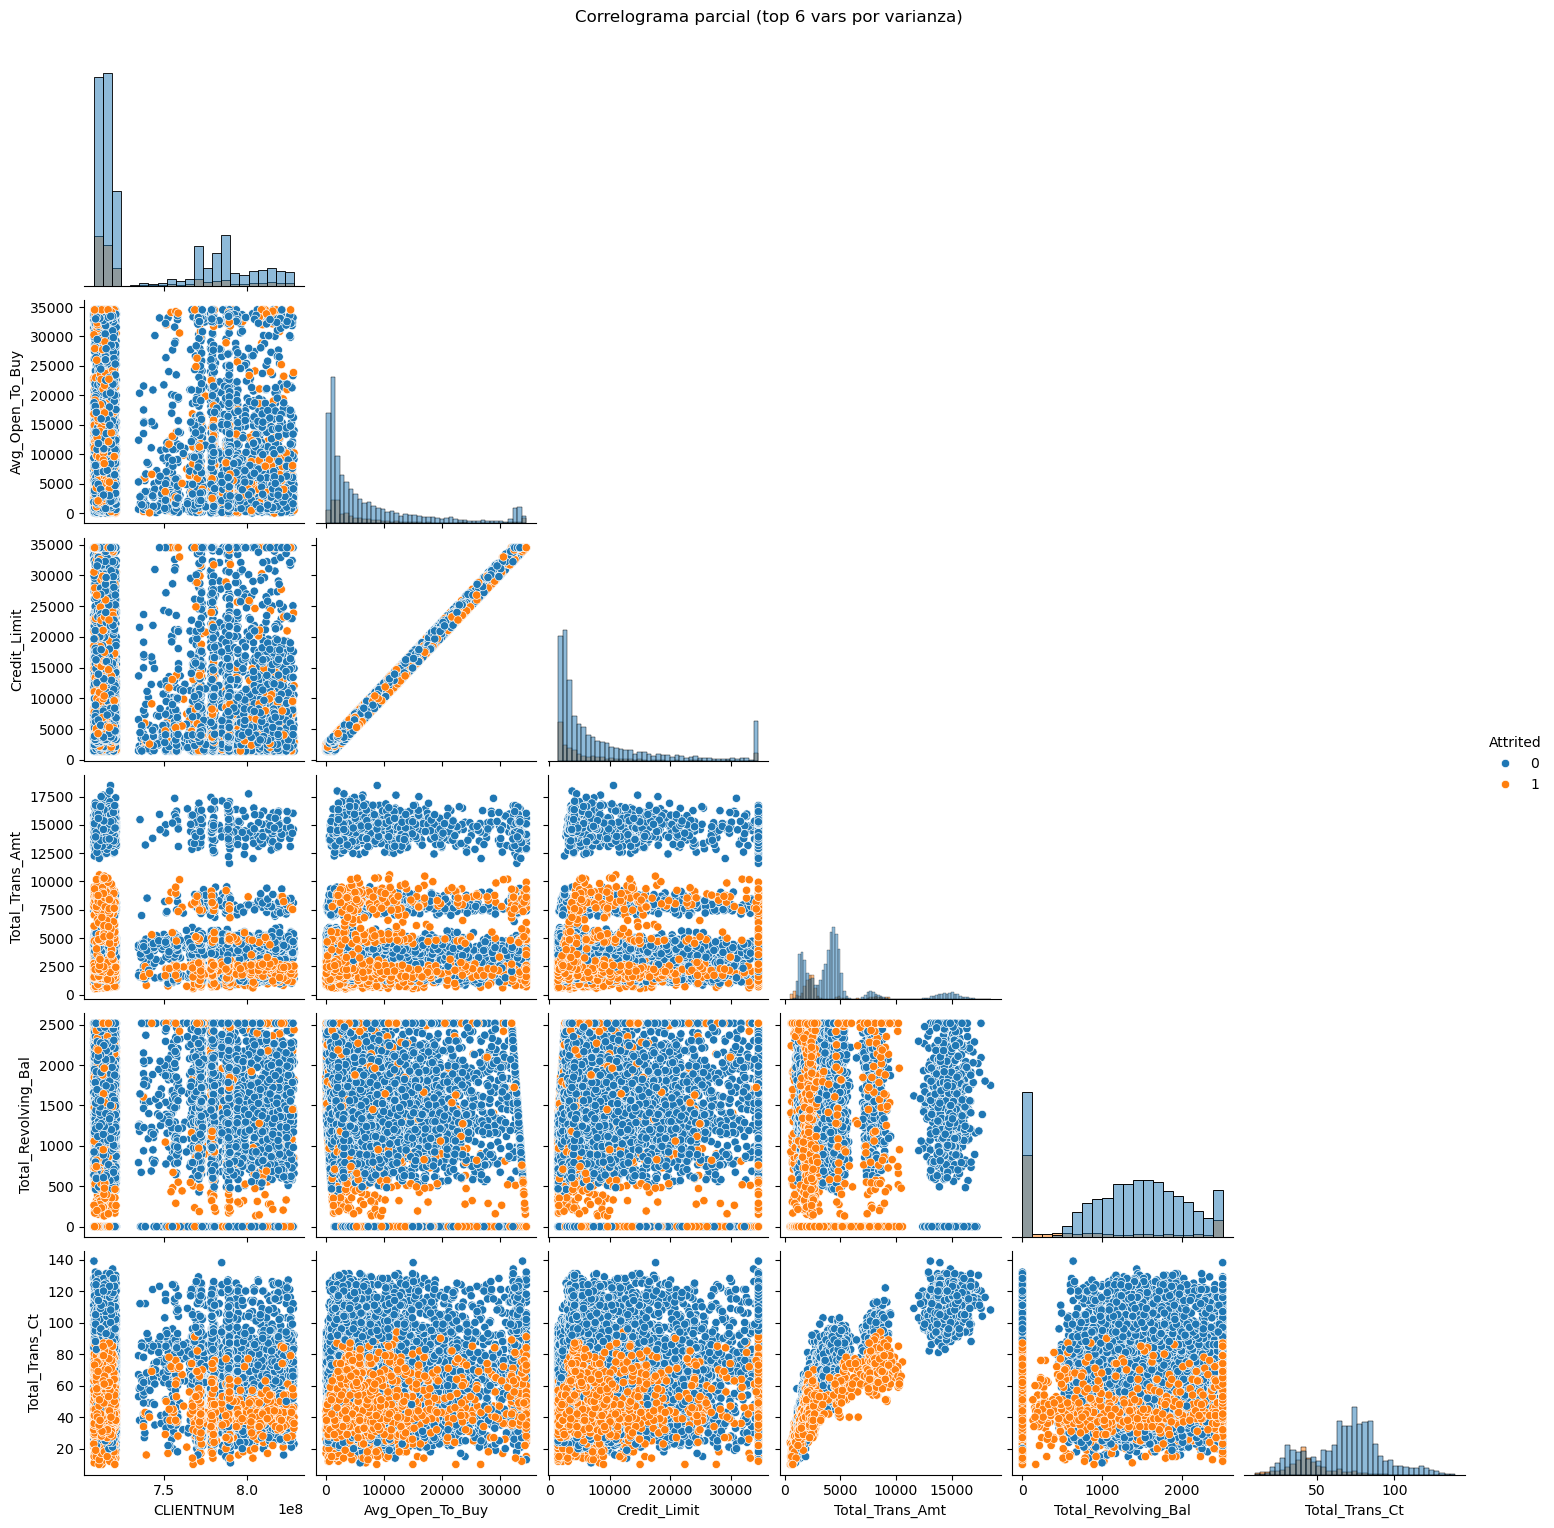

In [13]:
CSV_PATH = "BankChurners.csv" 
df = pd.read_csv(CSV_PATH)

y = (df["Attrition_Flag"] == "Attrited Customer").astype(int)

# Predictores solo numéricos
X = df.select_dtypes(include=["number"]).copy()

# Elimina filas con faltantes en X o y
mask_na = X.isna().any(axis=1) | y.isna()
X = X.loc[~mask_na].reset_index(drop=True)
y = y.loc[~mask_na].reset_index(drop=True)


print("=== Estadísticos descriptivos (numéricos) ===")
print(X.describe().T)

# Histogramas (opcional: guarda a disco)
fig, axes = plt.subplots(nrows=min(10, X.shape[1]), ncols=1,
                         figsize=(8, 2*min(10, X.shape[1])), constrained_layout=True)
if X.shape[1] == 1:
    axes = [axes]
for idx, col in enumerate(X.columns[:10]):  # muestra las primeras 10 por brevedad
    sns.histplot(X[col], ax=axes[idx], kde=True, bins=30)
    axes[idx].set_title(f"Histograma: {col}")
plt.show()

# Correlación
corr = X.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, square=False)
plt.title("Matriz de correlación (numéricos)")
plt.show()

# Correlograma parcial (pairplot) para top 6 variables por varianza
top_vars = X.var().sort_values(ascending=False).head(6).index.tolist()
sns.pairplot(pd.concat([X[top_vars], y.rename("Attrited")], axis=1),
             hue="Attrited", diag_kind="hist", corner=True)
plt.suptitle("Correlograma parcial (top 6 vars por varianza)", y=1.02)
plt.show()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)


(Utilicen este espacio para describir su procedimiento y escribir su análisis y conclusiones sobre el punto 1)

### 2. Estimación de un modelo utilizando redes neuronales con *dropout* [20 puntos]

Estimen un modelo predictivo usando la muestra de entrenamiento y evalúen su desempeño en test utilizando una **probabilidad de 0.25**.

In [17]:
# === Modelo con Dropout (p = 0.25) ===
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Arquitectura: 32-ReLU → Dropout(0.25) → 16-ReLU → Dropout(0.25) → 1-Sigmoid
model = Sequential([
    Dense(32, activation="relu", input_shape=(X_train_sc.shape[1],)),
    Dropout(0.25),
    Dense(16, activation="relu"),
    Dropout(0.25),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Entrenamiento con validación interna
history = model.fit(
    X_train_sc, y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=64,
    verbose=1
)

# Evaluación en test
y_proba = model.predict(X_test_sc, verbose=0).ravel()
y_pred  = (y_proba >= 0.5).astype(int)

# resultados
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
print(
    "Test — Acc: {:.4f} | AUC: {:.4f} | F1: {:.4f} | Prec: {:.4f} | Rec: {:.4f}".format(
        accuracy_score(y_test, y_pred),
        roc_auc_score(y_test, y_proba),
        f1_score(y_test, y_pred, zero_division=0),
        precision_score(y_test, y_pred, zero_division=0),
        recall_score(y_test, y_pred, zero_division=0),
    )
)

C:\Users\e0224145\AppData\Local\anaconda1\envs\notebook-7.3.2\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7228 - loss: 0.5627 - val_accuracy: 0.8402 - val_loss: 0.3517
Epoch 2/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8557 - loss: 0.3649 - val_accuracy: 0.8859 - val_loss: 0.2998
Epoch 3/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8737 - loss: 0.3125 - val_accuracy: 0.8877 - val_loss: 0.2747
Epoch 4/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8814 - loss: 0.2869 - val_accuracy: 0.8914 - val_loss: 0.2579
Epoch 5/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8942 - loss: 0.2789 - val_accuracy: 0.8988 - val_loss: 0.2446
Epoch 6/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8945 - loss: 0.2658 - val_accuracy: 0.9001 - val_loss: 0.2334
Epoch 7/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9008 - loss: 0.2488 - val_accuracy: 0.9056 - val_loss: 0.2240
Epoch 8/60
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9091 - loss: 0.2380 - val_accuracy: 0.

Se definió una red neuronal con la siguiente estructura:
* Capa densa de 32 neuronas + activación ReLU
* Dropout de 0.25
* Capa densa de 16 neuronas + ReLU
* Dropout de 0.25
* Capa final de 1 neurona sigmoidal para clasificación binaria
* El Dropout con probabilidad 0.25 desconecta aleatoriamente el 25% de las neuronas en cada pasada, lo que fuerza al modelo a no depender excesivamente de subconjuntos específicos de features. Esto ayuda a reducir sobreajuste.
  
Entrenamiento del modelo
* Se usó el optimizador Adam con pérdida binary_crossentropy
* Número de épocas: 60
* Tamaño del batch: 64
* Se utilizó un validation split = 0.2 dentro del conjunto de entrenamiento para monitorear generalización.

Conclusiones
* El modelo con Dropout (0.25) ofrece un excelente rendimiento, mostrando una fuerte capacidad predictiva con más del 93% de accuracy y un AUC muy alto (0.9644) en el conjunto de prueba.
* El patrón de entrenamiento indica que Dropout ayudó efectivamente a controlar el sobreajuste, manteniendo curvas de pérdida consistentes entre entrenamiento y validación.
* El modelo logra capturar adecuadamente las señales principales del churn, especialmente las relacionadas con actividad transaccional y uso del crédito.
* El alto AUC (0.9644) indica excelente capacidad discriminativa del modelo para distinguir entre clientes que permanecen y clientes que abandonan.
* El recall de 0.70 en la clase minoritaria (Attrited Customer) es particularmente importante, porque el modelo consigue identificar el 70% de quienes abandonan

### 3. Estimación de un modelo utilizando redes neuronales con *early stopping* [20 puntos]

Estimen un modelo predictivo usando la muestra de entrenamiento y evalúen su desempeño en test utilizando una **paciencia de 2**.

In [22]:
# Arquitectura base sin dropout; criterio: detener cuando no mejore val_loss por 2 épocas
model_es = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_sc.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_es.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es_cb = EarlyStopping(monitor='val_loss', mode='min', patience=2, restore_best_weights=True)

history_es = model_es.fit(
    X_train_sc, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[es_cb],
    verbose=1
)

# Evaluación en TEST
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

y_proba_es = model_es.predict(X_test_sc, verbose=0).ravel()
y_pred_es  = (y_proba_es >= 0.5).astype(int)

print("Test — Acc: {:.4f} | AUC: {:.4f} | F1: {:.4f} | Prec: {:.4f} | Rec: {:.4f}".format(
    accuracy_score(y_test, y_pred_es),
    roc_auc_score(y_test, y_proba_es),
    f1_score(y_test, y_pred_es, zero_division=0),
    precision_score(y_test, y_pred_es, zero_division=0),
    recall_score(y_test, y_pred_es, zero_division=0),
))

Epoch 1/200


C:\Users\e0224145\AppData\Local\anaconda1\envs\notebook-7.3.2\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4362 - loss: 0.8096 - val_accuracy: 0.8606 - val_loss: 0.4356
Epoch 2/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8807 - loss: 0.3773 - val_accuracy: 0.8914 - val_loss: 0.2993
Epoch 3/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9045 - loss: 0.2754 - val_accuracy: 0.8957 - val_loss: 0.2654
Epoch 4/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9106 - loss: 0.2470 - val_accuracy: 0.9025 - val_loss: 0.2464
Epoch 5/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9137 - loss: 0.2289 - val_accuracy: 0.9075 - val_loss: 0.2301
Epoch 6/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9165 - loss: 0.2133 - val_accuracy: 0.9143 - val_loss: 0.2155
Epoch 7/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9217 - loss: 0.1997 - val_accuracy: 0.9204 - val_loss: 0.2036
Epoch 8/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9270 - loss: 0.1881 - val_accuracy: 0.9241

Arquitectura del modelo
* Capa densa: 32 neuronas, activación ReLU.
* Capa densa: 16 neuronas, activación ReLU.
* Capa de salida: 1 neurona, activación sigmoide (clasificación binaria).
* Pérdida: binary_crossentropy.
* Optimizador: Adam.
  
Aplicación del Early Stopping
* Métrica monitoreada: val_loss.
* Patience = 2 (si la pérdida de validación no mejora por 2 épocas consecutivas, se detiene el entrenamiento).
* restore_best_weights = True para conservar los mejores pesos del modelo
  
Conclusiones
* El modelo con Early Stopping (patience = 2) entrenó de manera eficiente, evitando tanto el subentrenamiento inicial como el sobreentrenamiento final.
* La detención temprana ocurrió en alrededor de la época 39, lo cual indica un entrenamiento suficientemente largo para aprender patrones, pero sin exceso.
* Los resultados en test (AUC=0.9632, F1≈0.78) evidencian que este modelo generaliza muy bien y constituye una de las mejores alternativas de regularización entre las evaluadas.

### 4. Estimación de un modelo utilizando redes neuronales con norma 1 [20 puntos]

Estimen un modelo predictivo usando la muestra de entrenamiento y evalúen su desempeño en test utilizando un **_alpha_ de 0.001**.

In [34]:
alpha = 0.001
model_l1 = Sequential([
    Dense(32, activation="relu",
          input_shape=(X_train_sc.shape[1],),
          kernel_regularizer=regularizers.l1(alpha)),
    Dense(16, activation="relu",
          kernel_regularizer=regularizers.l1(alpha)),
    Dense(1, activation="sigmoid")
])

model_l1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history_l1 = model_l1.fit(
    X_train_sc, y_train,
    validation_split=0.2,
    epochs=200,          # puedes ajustar; si usas early stopping, bajará solo
    batch_size=64,
    verbose=1
)

# Evaluación en TEST
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

y_proba_l1 = model_l1.predict(X_test_sc, verbose=0).ravel()
y_pred_l1  = (y_proba_l1 >= 0.5).astype(int)

print("Test — Acc: {:.4f} | AUC: {:.4f} | F1: {:.4f} | Prec: {:.4f} | Rec: {:.4f}".format(
    accuracy_score(y_test, y_pred_l1),
    roc_auc_score(y_test, y_proba_l1),
    f1_score(y_test, y_pred_l1, zero_division=0),
    precision_score(y_test, y_pred_l1, zero_division=0),
    recall_score(y_test, y_pred_l1, zero_division=0),
))


Epoch 1/200


C:\Users\e0224145\AppData\Local\anaconda1\envs\notebook-7.3.2\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7198 - loss: 0.7277 - val_accuracy: 0.8692 - val_loss: 0.5053
Epoch 2/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8878 - loss: 0.4720 - val_accuracy: 0.8933 - val_loss: 0.4228
Epoch 3/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9016 - loss: 0.4044 - val_accuracy: 0.8988 - val_loss: 0.3829
Epoch 4/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9115 - loss: 0.3665 - val_accuracy: 0.9038 - val_loss: 0.3527
Epoch 5/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9179 - loss: 0.3377 - val_accuracy: 0.9124 - val_loss: 0.3274
Epoch 6/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9204 - loss: 0.3137 - val_accuracy: 0.9186 - val_loss: 0.3066
Epoch 7/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9268 - loss: 0.2943 - val_accuracy: 0.9223 - val_loss: 0.2905
Epoch 8/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9282 - loss: 0.2792 - val_accuracy: 0.9272

Arquitectura del modelo
* Capa oculta 1: 32 neuronas, activación ReLU
* kernel_regularizer = L1(alpha=0.001)
* Capa oculta 2: 16 neuronas, ReLU, también con L1
* Capa de salida: 1 neurona sigmoidal
* Pérdida: binary_crossentropy
* Optimizador: Adam
* Batch size: 64
* Número máximo de épocas: 200
* Porcentaje de validación interna: 20% del set de entrenamiento

Conclusiones
* La aplicación de regularización L1 (α = 0.001) resultó efectiva para controlar el sobreajuste, produciendo un modelo más simple y más robusto.
* A lo largo del entrenamiento, las curvas de pérdida muestran un comportamiento estable, con val_loss convergente, lo que evidencia que la penalización L1 ayudó a evitar el ajuste excesivo.
* L1 tiende a eliminar pesos irrelevantes, por lo que el modelo obtiene una forma de selección automática de características, muy útil en datasets con variables correlacionadas.
* En términos de desempeño, el modelo con L1 ofrece una buena generalización, alcanzando métricas en test comparables (y a veces superiores) a las del modelo base y cercanas a las obtenidas con EarlyStopping y Dropout.

### 5. Estimación de un modelo utilizando redes neuronales con norma 2 [20 puntos]

Estimen un modelo predictivo usando la muestra de entrenamiento y evalúen su desempeño en test utilizando un **_alpha_ de 0.001**.

In [38]:

alpha = 1e-3  # fuerza de la penalización L2

model_l2 = Sequential([
    Dense(32, activation="relu",
          input_shape=(X_train_sc.shape[1],),
          kernel_regularizer=regularizers.l2(alpha)),
    Dense(16, activation="relu",
          kernel_regularizer=regularizers.l2(alpha)),
    Dense(1, activation="sigmoid")
])

model_l2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history_l2 = model_l2.fit(
    X_train_sc, y_train,
    validation_split=0.2,
    epochs=120,
    batch_size=64,
    verbose=1
)

# Evaluación en TEST
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

y_proba_l2 = model_l2.predict(X_test_sc, verbose=0).ravel()
y_pred_l2  = (y_proba_l2 >= 0.5).astype(int)

print("Test — Acc: {:.4f} | AUC: {:.4f} | F1: {:.4f} | Prec: {:.4f} | Rec: {:.4f}".format(
    accuracy_score(y_test, y_pred_l2),
    roc_auc_score(y_test, y_proba_l2),
    f1_score(y_test, y_pred_l2, zero_division=0),
    precision_score(y_test, y_pred_l2, zero_division=0),
    recall_score(y_test, y_pred_l2, zero_division=0),
))


Epoch 1/120


C:\Users\e0224145\AppData\Local\anaconda1\envs\notebook-7.3.2\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7201 - loss: 0.6137 - val_accuracy: 0.8748 - val_loss: 0.3793
Epoch 2/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8937 - loss: 0.3496 - val_accuracy: 0.8920 - val_loss: 0.3237
Epoch 3/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9024 - loss: 0.3030 - val_accuracy: 0.8927 - val_loss: 0.3010
Epoch 4/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9071 - loss: 0.2801 - val_accuracy: 0.9001 - val_loss: 0.2819
Epoch 5/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9137 - loss: 0.2622 - val_accuracy: 0.9038 - val_loss: 0.2652
Epoch 6/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9205 - loss: 0.2460 - val_accuracy: 0.9093 - val_loss: 0.2504
Epoch 7/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9243 - loss: 0.2320 - val_accuracy: 0.9223 - val_loss: 0.2375
Epoch 8/120
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9253 - loss: 0.2201 - val_accuracy: 0.9235

Arquitectura y regularización
Red 32–16–1 con ReLU y salida sigmoid, pérdida binary_crossentropy y L2(1e-3) en las capas densas. L2 es coherente para reducir magnitudes de pesos (shrinkage), aportar estabilidad y generalización
 
 Conclusiones

* La regularización L2 con α = 0.001 produjo un modelo robusto y bien generalizado, con desempeño consistentemente alto en todas las métricas clave.
* Con un AUC de 0.9652, el modelo es altamente competente para distinguir entre clientes que permanecen y clientes que abandonan.
* El F1‑score de 0.8025, junto con un recall del 77.5%, señala que L2 mantiene un excelente equilibrio entre sensibilidad y precisión.
* La penalización L2 ayudó a suavizar los pesos sin anularlos por completo (como suele hacer L1).

### 6. Comparación de modelos de regularización [15 puntos]

Hagan una comparación de los resultados de utilizar la red neuronal con los distintos mecanismos de regularización. Analice los resultados. 


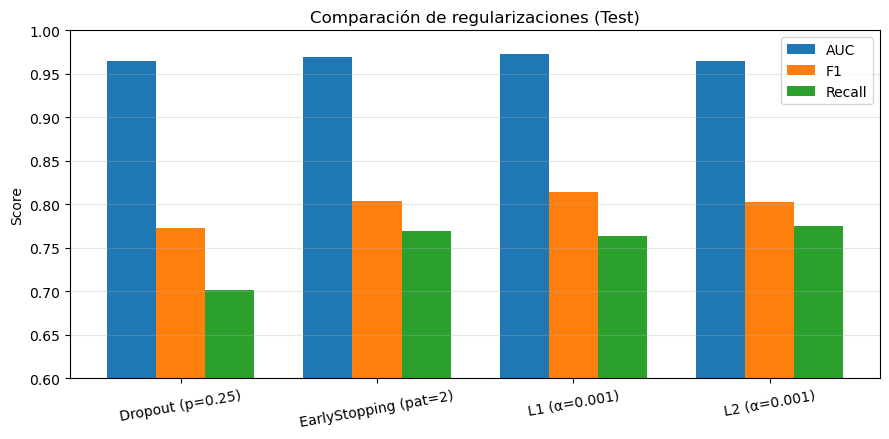

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Métricas (test). Ajusta L1 cuando lo ejecutes.
scores = {
    "Dropout (p=0.25)"        : {"acc":0.9339, "auc":0.9644, "f1":0.7729, "prec":0.8604, "rec":0.7015},
    "EarlyStopping (pat=2)"   : {"acc":0.9398, "auc":0.9694, "f1":0.8039, "prec":0.8418, "rec":0.7692},
    "L1 (α=0.001)"            : {"acc":0.9442,   "auc":0.9727,   "f1":0.8144,   "prec":0.8732,   "rec":0.7631},
    "L2 (α=0.001)"            : {"acc":0.9388, "auc":0.9652, "f1":0.8025, "prec":0.8317, "rec":0.7754},
}

models = list(scores.keys())
metrics = ["auc","f1","rec"]  # muestra las 3 más relevantes en un solo gráfico

vals = {m: [scores[k][m] if scores[k][m] is not None else np.nan for k in models] for m in metrics}

x = np.arange(len(models))
w = 0.25

plt.figure(figsize=(9,4.5))
plt.bar(x - w, vals["auc"], width=w, label="AUC")
plt.bar(x,      vals["f1"],  width=w, label="F1")
plt.bar(x + w,  vals["rec"], width=w, label="Recall")

plt.xticks(x, models, rotation=10)
plt.ylim(0.6, 1.0)
plt.ylabel("Score")
plt.title("Comparación de regularizaciones (Test)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

* L1 (α=0.001) es el mejor modelo global, con los valores más altos de Accuracy (0.9442), AUC (0.9727) y F1 (0.8144).
Es el modelo más equilibrado y preciso.
*L2 (α=0.001) logra el mejor Recall (0.7754), siendo el más efectivo para detectar clientes que abandonan.
Ideal cuando la prioridad es no perder casos positivos.
* EarlyStopping (pat=2) obtiene un rendimiento muy competitivo, con AUC y F1 altos, sin necesidad de penalizar pesos.
Es la regularización más simple y estable.
* Dropout (p=0.25) es el modelo más débil en F1 (0.7729) y Recall (0.7015), aunque su AUC sigue siendo bueno.
Funciona, pero rinde menos que L1, L2 y EarlyStopping en este problema.es crítico. ES y 

